# 🌍 Land cover classification

Choose a location for Vertex AI https://cloud.google.com/vertex-ai/docs/general/locations

ℹ️ Make sure the Cloud Storage bucket is in the same region https://cloud.google.com/storage/docs/locations (NOT MULTI REGION)

Create bucket: https://console.cloud.google.com/storage/create-bucket

Enable APIs (TODO): Dataflow, Earth Engine, Vertex AI, Cloud Run
https://console.cloud.google.com/flows/enableapi?apiid=dataflow.googleapis.com,earthengine.googleapis.com,aiplatform.googleapis.com,run.googleapis.com

Register Compute Engine service account to EE: https://signup.earthengine.google.com/#!/service_accounts
from https://console.cloud.google.com/iam-admin/iam

In [1]:
# TODO: UPDATE WITH main BRANCH!
# github_path = 'https://raw.githubusercontent.com/GoogleCloudPlatform/python-docs-samples/main/people-and-planet-ai/land-cover-classification'
github_path = 'https://raw.githubusercontent.com/davidcavazos/python-docs-samples/ppai-landcover/people-and-planet-ai/land-cover-classification'

!pip install -r {github_path}/requirements.txt -c {github_path}/constraints.txt

     |████████████████████████████████| 10.2 MB 5.1 MB/s 
     |████████████████████████████████| 95 kB 2.6 MB/s 
     |████████████████████████████████| 1.8 MB 55.7 MB/s 
     |████████████████████████████████| 3.4 MB 40.5 MB/s 
     |████████████████████████████████| 11.2 MB 8.5 MB/s 
     |████████████████████████████████| 56 kB 2.4 MB/s 
     |████████████████████████████████| 107 kB 65.3 MB/s 
     |████████████████████████████████| 206 kB 71.6 MB/s 
     |████████████████████████████████| 46 kB 1.2 MB/s 
     |████████████████████████████████| 402 kB 79.0 MB/s 
     |████████████████████████████████| 4.3 MB 39.9 MB/s 
     |████████████████████████████████| 930 kB 56.5 MB/s 
     |████████████████████████████████| 462 kB 30.5 MB/s 
     |████████████████████████████████| 508 kB 63.6 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 253 kB 75.5 MB/s 
     |████████████████████████████████| 151 kB 47.3 MB/s 
     |████████████████

# ⚠️ RESTART RUNTIME

In [1]:
# TODO: DELETE THIS, BACKDOOR FOR TESTING
import os
os.environ['GOOGLE_CLOUD_PROJECT'] = 'dcavazos-lyra'
os.environ['CLOUD_STORAGE_BUCKET'] = 'dcavazos-lyra'

In [2]:
#@title My Google Cloud resources
project = "" #@param {type:"string"}
bucket = "" #@param {type:"string"}
location = "us-central1" #@param {type:"string"}

# Load from environment variables if available.
import os
project = os.environ.get('GOOGLE_CLOUD_PROJECT', project)
bucket = os.environ.get('CLOUD_STORAGE_BUCKET', bucket)
location = os.environ.get('CLOUD_LOCATION', location)

# Quick input validations.
assert project, '⚠️ Please provide a Google Cloud project ID'
assert bucket, '⚠️ Please provide a Cloud Storage bucket name'
assert not bucket.startswith('gs://'), f'⚠️ Please remove the gs:// prefix from the bucket name: {bucket}'
assert location, '⚠️ Please provide a Google Cloud location'

# Authenticate.
from google.colab import auth
auth.authenticate_user()

In [3]:
import ee
import google.auth

credentials, _ = google.auth.default(
    scopes=[
        'https://www.googleapis.com/auth/cloud-platform',
        'https://www.googleapis.com/auth/earthengine',
    ]
)
ee.Initialize(
    credentials,
    project=project,
    # opt_url="https://earthengine-highvolume.googleapis.com",
)

# Understand the data

- What is a land cover map?
- Why Sentinel 2 as inputs?
- Model input and output shapes

In [4]:
CLASSIFICATIONS = {
    '💧 Water':              '449cda',
    '🌳 Trees':              '3d7c49',
    '🌾 Grass':              '8ab052',
    '🌿 Flooded vegetation': '7c86c7',
    '🚜 Crops':              'e19832',
    '🪴 Shrub and scrub':    'dfc35b',
    '🏗️ Built-up areas':     'c52918',
    '🪨 Bare ground':        'a29d90',
    '❄️ Snow and ice':       'b4a0e0',
}
PALETTE = list(CLASSIFICATIONS.values())

def display_legend():
  reset_color = '\u001b[0m'
  colored = lambda red, green, blue: f"\033[48;2;{red};{green};{blue}m"
  for name, color in CLASSIFICATIONS.items():
    red   = int(color[0:2], 16)
    green = int(color[2:4], 16)
    blue  = int(color[4:6], 16)
    print(f"{colored(red, green, blue)}   {reset_color} {name}")

display_legend()

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


## **Inputs**: Sentinel 2 satellite images

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

Mask (hide) pixels covered by clouds or cirrus clouds.

TODO: explain how to mask clouds

Example: Cananea Copper Mine, Sonora, Mexico.
https://earthobservatory.nasa.gov/images/8680/cananea-copper-mine-sonora-mexico


In [8]:
import folium

SENTINEL2_BANDS = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B10", "B11", "B12"]

def sentinel2_image(start_date: str, end_date: str) -> ee.Image:
    def mask_sentinel2_clouds(image: ee.Image) -> ee.Image:
        CLOUD_BIT = 10
        CIRRUS_CLOUD_BIT = 11
        bit_mask = (1 << CLOUD_BIT) | (1 << CIRRUS_CLOUD_BIT)
        mask = image.select("QA60").bitwiseAnd(bit_mask).eq(0)
        return image.updateMask(mask)

    return (
        ee.ImageCollection("COPERNICUS/S2")
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
        .map(mask_sentinel2_clouds)
        .median()
    )

image = sentinel2_image('2020-1-1', '2021-01-1')

vis_params = {
  'min': 0,
  'max': 4000,
  'bands': ['B4', 'B3', 'B2'],
}
folium.Map(
    location=(30.95, -110.29),
    zoom_start=13,
    tiles=image.getMapId(vis_params)['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

## **Outputs**: Land cover map

https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100

In [9]:
import folium

def landcover_image() -> ee.Image:
    # Remap the ESA classifications into the Dynamic World classifications
    fromValues = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]
    toValues = [1, 5, 2, 4, 6, 7, 8, 0, 3, 3, 7]
    return (
        ee.ImageCollection("ESA/WorldCover/v100")
        .first()
        .select("Map")
        .remap(fromValues, toValues)
        .rename("landcover")
    )

image = landcover_image()

vis_params = {
  'bands': ['landcover'],
  'palette': PALETTE,
}
folium.Map(
    location=(30.95, -110.29),
    zoom_start=13,
    tiles=image.getMapId(vis_params)['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

In [10]:
display_legend()

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


TODO: add note on how to use dynamic world

# Create the datasets

## Sample training points

In [11]:
import random
from typing import Dict, Iterable, Tuple

def sample_random_points(region: Dict[str, float], points_per_region: int = 10) -> Iterable[Tuple[float, float]]:
  for _ in range(points_per_region):
    lat = random.uniform(region["south"], region["north"])
    lon = random.uniform(region["west"], region["east"])
    yield (lat, lon)

region = {"west": -23.526, "south":  60.537, "east": -15.526, "north":  68.537}
for coords in sample_random_points(region, points_per_region=5):
  print(f"coords: {coords}")

coords: (65.92211990538728, -18.198428597252807)
coords: (62.84641868263438, -16.23559004203608)
coords: (63.27895561689367, -20.559822754389646)
coords: (66.3923055095495, -20.65973680593179)
coords: (67.5883877929378, -21.432185057898863)


## Get patches from Earth Engine

In [12]:
import io
import numpy as np
import requests
from typing import List

INPUT_BANDS = SENTINEL2_BANDS
OUTPUT_BANDS = ["landcover"]

def get_patch(image: ee.Image, lat: float, lon: float, bands: List[str], patch_size: int, scale: int) -> np.ndarray:
  point = ee.Geometry.Point([lon, lat])
  region = point.buffer(scale * patch_size / 2, 1).bounds(1)
  url = image.getDownloadURL({
      "region": region,
      "dimensions": [patch_size, patch_size],
      "format": "NPY",
      "bands": bands,
  })

  response = requests.get(url)
  response.raise_for_status()

  print(f"Got patch for {(lat, lon)}")
  return np.load(io.BytesIO(response.content), allow_pickle=True)


def get_training_patch(lat: float, lon: float, bands: List[str] = [], patch_size: int = 16) -> np.ndarray:
    image = sentinel2_image("2020-1-1", "2021-1-1").addBands(landcover_image())
    return get_patch(image, lat, lon, bands, patch_size, scale=10)


(lat, lon) = (30.972, -110.312)
bands = INPUT_BANDS + OUTPUT_BANDS
patch = get_training_patch(lat, lon, bands, patch_size=128)
print(f"patch shape={patch.shape} bands={len(patch.dtype)}")
print(f"dtype: {patch.dtype}")

Got patch for (30.972, -110.312)
patch shape=(128, 128) bands=14
dtype: [('B1', '<f8'), ('B2', '<f8'), ('B3', '<f8'), ('B4', '<f8'), ('B5', '<f8'), ('B6', '<f8'), ('B7', '<f8'), ('B8', '<f8'), ('B8A', '<f8'), ('B9', '<f8'), ('B10', '<f8'), ('B11', '<f8'), ('B12', '<f8'), ('landcover', 'u1')]


## Visualize training data

sentinel2_rgb: uint8 (128, 128, 3)


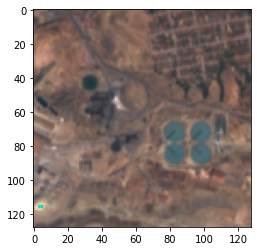

In [13]:
import matplotlib.pyplot as plt

def render_rgb_images(values: np.ndarray, min=0.0, max=1.0) -> np.ndarray:
  scaled_values = (values - min) / (max - min)
  rgb_values = scaled_values * 255
  return rgb_values.astype(np.uint8)

def render_sentinel2(patch: np.ndarray, min=0.0, max=2500.0) -> np.ndarray:
  red   = patch['B4']
  green = patch['B3']
  blue  = patch['B2']
  rgb_patch = np.stack([red, green, blue], axis=-1)
  return render_rgb_images(rgb_patch, min, max)

sentinel2_rgb = render_sentinel2(patch, max=4000)

print(f"sentinel2_rgb: {sentinel2_rgb.dtype} {sentinel2_rgb.shape}")
plt.imshow(sentinel2_rgb)

landcover_rgb: uint8 (128, 128, 3)
    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


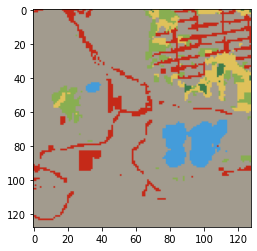

In [14]:
from typing import List

def render_classifications(values: np.ndarray, palette: List[str]) -> np.ndarray:
  # Create a color map from a hex color palette.
  xs = np.linspace(0, len(palette), 256)
  indices = np.arange(len(palette))
  color_map = np.array([
        np.interp(xs, indices, [int(c[0:2], 16) for c in palette]),  # red
        np.interp(xs, indices, [int(c[2:4], 16) for c in palette]),  # green
        np.interp(xs, indices, [int(c[4:6], 16) for c in palette]),  # blue
  ]).astype(np.uint8).transpose()

  color_indices = (values / len(palette) * 255).astype(np.uint8)
  return np.take(color_map, color_indices, axis=0)

def render_landcover(patch: np.ndarray) -> np.ndarray:
  return render_classifications(patch, PALETTE)

landcover_rgb = render_landcover(patch['landcover'])

print(f"landcover_rgb: {landcover_rgb.dtype} {landcover_rgb.shape}")
plt.imshow(landcover_rgb)
display_legend()

## Serialize into TFRecords

In [15]:
import tensorflow as tf
from typing import List

def serialize(patch: np.ndarray) -> bytes:
    features = {
        name: tf.train.Feature(
            float_list=tf.train.FloatList(value=patch[name].flatten())
        )
        for name in patch.dtype.names
    }
    example = tf.train.Example(features=tf.train.Features(feature=features))
    return example.SerializeToString()

serialized = serialize(patch)
print(f"serialized: {type(serialized).__name__} ({len(serialized)})")

serialized: bytes (917799)


## Create the datasets in Beam

https://beam.apache.org/documentation/runners/direct/#parallel-execution

In [16]:
import apache_beam as beam
import random

points_per_region = 3
patch_size = 8
validation_ratio = 0.1

regions = [
    {'west': -23.52612501549789, 'south': 60.537419468065266, 'east': -15.52612501549789, 'north': 68.53741946806527},
    {'west': -67.59807581246808, 'south': -22.174451161190976, 'east': -59.59807581246808, 'north': -14.174451161190976},
    {'west': 43.0239394222872, 'south': -22.587009343759828, 'east': 51.0239394222872, 'north': -14.587009343759828},
    {'west': 129.60566704275857, 'south': -20.95215440837891, 'east': 137.60566704275857, 'north': -12.95215440837891},
    {'west': 23.920116850704154, 'south': 64.335401033452, 'east': 31.920116850704154, 'north': 72.335401033452},
    {'west': 75.81476560544857, 'south': 33.26669570082987, 'east': 83.81476560544857, 'north': 41.26669570082987},
    {'west': 7.730049413335555, 'south': 51.549317575488274, 'east': 15.730049413335555, 'north': 59.549317575488274},
    {'west': -73.3484470900119, 'south': 6.042122511849252, 'east': -65.3484470900119, 'north': 14.042122511849252},
    {'west': 42.79965725100932, 'south': 21.073901600571684, 'east': 50.79965725100932, 'north': 29.073901600571684},
    {'west': 60.45770180234513, 'south': 63.87910316649173, 'east': 68.45770180234513, 'north': 71.87910316649173},
]

def split_dataset(element, num_partitions: int) -> int:
  weights = [1 - validation_ratio, validation_ratio]
  return random.choices([0, 1], weights)[0]

with beam.Pipeline() as pipeline:
  training_data, validation_data = (
      pipeline
      | "Create regions" >> beam.Create(regions)
      | "Sample random points" >> beam.FlatMap(sample_random_points, points_per_region)
      | "Get patch" >> beam.MapTuple(get_training_patch, bands, patch_size)
      | "Serialize" >> beam.Map(serialize)
      | "Split dataset" >> beam.Partition(split_dataset, 2)
  )

  training_data | "Write training data" >> beam.io.tfrecordio.WriteToTFRecord(
      "datasets/training", file_name_suffix=".tfrecord.gz"
  )
  validation_data | "Write validation data" >> beam.io.tfrecordio.WriteToTFRecord(
      "datasets/validation", file_name_suffix=".tfrecord.gz"
  )

Got patch for (63.17540233110974, -23.298017973464816)
Got patch for (64.74178925189395, -18.019150427240135)
Got patch for (64.23163576523523, -22.420778167643334)
Got patch for (-20.45309839919025, -60.900901323494395)
Got patch for (-20.051307087854994, -63.78078593527031)
Got patch for (-21.547004707800752, -60.68843440667686)
Got patch for (-20.34504941403541, 44.93426742496417)
Got patch for (-16.91569245858286, 47.06469915503679)
Got patch for (-17.313753974189616, 45.55674467103395)
Got patch for (-16.935071854298954, 136.0369717042487)
Got patch for (-18.184009351229317, 137.2993463318311)
Got patch for (-14.446831377056142, 132.12393252802516)
Got patch for (69.94863579626238, 28.80595270342159)
Got patch for (68.54132390878239, 31.147082894344667)
Got patch for (69.13975146476103, 30.903386358622992)
Got patch for (33.61477264480975, 77.42989258878303)
Got patch for (37.54641367849536, 81.50287553489328)
Got patch for (33.40171316951196, 77.90131700132032)
Got patch for (58.

In [17]:
!ls -lh datasets/*.tfrecord.gz

-rw-r--r-- 1 root root  28K Apr 28 16:07 datasets/training-00000-of-00001.tfrecord.gz
-rw-r--r-- 1 root root 2.4K Apr 28 16:07 datasets/validation-00000-of-00001.tfrecord.gz


# Train the model

## Inspect the datasets

In [18]:
import tensorflow as tf

filenames = tf.data.Dataset.list_files(f"datasets/training*.tfrecord.gz")
dataset = tf.data.TFRecordDataset(filenames, compression_type='GZIP')
for x in dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(x.numpy())
  for _, feature in example.ListFields():
    for _, field in feature.ListFields():
      for name, values in sorted(field.items()):
        print(f"{name}: float ({len(values.float_list.value)})")

B1: float (64)
B10: float (64)
B11: float (64)
B12: float (64)
B2: float (64)
B3: float (64)
B4: float (64)
B5: float (64)
B6: float (64)
B7: float (64)
B8: float (64)
B8A: float (64)
B9: float (64)
landcover: float (64)


## Read the datasets

In [19]:
print(f"Number of classifications: {len(CLASSIFICATIONS)}")
print(f"Training patch size: {patch_size}")
print(f"Training patch area: {patch_size * patch_size}")

Number of classifications: 9
Training patch size: 8
Training patch area: 64


https://www.tensorflow.org/guide/data_performance

In [20]:
from typing import Dict, Tuple

def preprocess(patch: Dict[str, tf.Tensor]) -> Tuple[tf.Tensor, tf.Tensor]:
    inputs = tf.stack([patch[band] for band in INPUT_BANDS], axis=-1)
    outputs = tf.one_hot(tf.cast(patch["landcover"], tf.uint8), len(CLASSIFICATIONS))
    return (inputs, outputs)

def read_dataset(file_pattern: str, patch_size: int, batch_size: int) -> tf.data.Dataset:
  input_shape = (patch_size, patch_size)
  features_dict = {
      band_name: tf.io.FixedLenFeature(input_shape, tf.float32)
      for band_name in INPUT_BANDS + OUTPUT_BANDS
  }
  return (
      tf.data.Dataset.list_files(file_pattern)
      .interleave(lambda filename: tf.data.TFRecordDataset(filename, compression_type="GZIP"))
      .batch(batch_size)
      .map(lambda batch: tf.io.parse_example(batch, features_dict))
      .map(preprocess)
  )

training_dataset = read_dataset(f"datasets/training*.tfrecord.gz", patch_size, batch_size=16)
validation_dataset = read_dataset(f"datasets/validation*.tfrecord.gz", patch_size, batch_size=16)
for inputs, outputs in training_dataset.take(1):
  print(f"inputs:  {inputs.shape}")
  print(f"outputs: {outputs.shape}")

inputs:  (16, 8, 8, 13)
outputs: (16, 8, 8, 9)


(batch_size, width, height, num_bands)

## Model architecture

TODO: add diagram

- https://keras.io/api/layers/core_layers/input/
- https://keras.io/api/layers/preprocessing_layers/numerical/normalization/
- https://keras.io/api/layers/convolution_layers/convolution2d/
- https://keras.io/api/layers/convolution_layers/convolution2d_transpose/
- https://keras.io/api/layers/core_layers/dense/
- https://keras.io/api/optimizers/
- https://keras.io/api/losses/

In [21]:
kernel_size = 5 #@param {type:"integer"}

Model: "land-cover-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Normalized (Normalization)  (None, None, None, 13)    27        
                                                                 
 conv2D (Conv2D)             (None, None, None, 32)    10432     
                                                                 
 deconv2D (Conv2DTranspose)  (None, None, None, 16)    12816     
                                                                 
 landcover (Dense)           (None, None, None, 9)     153       
                                                                 
Total params: 23,428
Trainable params: 23,401
Non-trainable params: 27
_________________________________________________________________


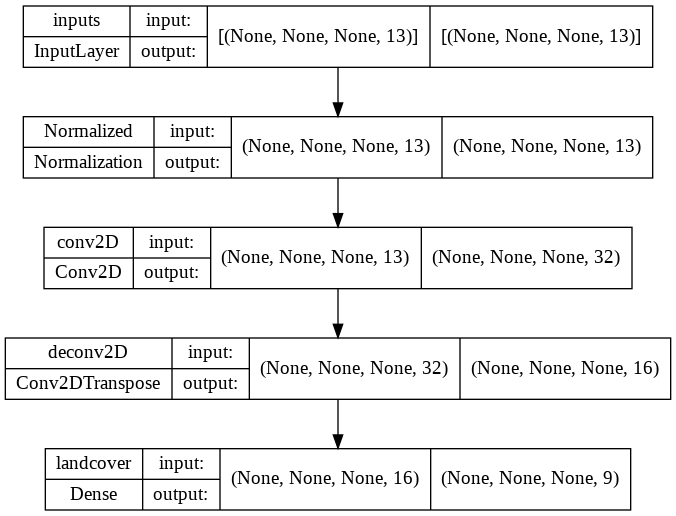

In [22]:
import tensorflow as tf

normalization = tf.keras.layers.Normalization(name="Normalized")
normalization.adapt(training_dataset.map(lambda x, _: x))

layers = [
    tf.keras.Input(shape=(None, None, len(INPUT_BANDS)), name="inputs"),
    normalization,
    tf.keras.layers.Conv2D(filters=32, kernel_size=kernel_size, activation="relu", name="conv2D"),
    tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=kernel_size, activation="relu", name="deconv2D"),
    tf.keras.layers.Dense(len(CLASSIFICATIONS), activation="softmax", name="landcover"),
]
model = tf.keras.Sequential(layers, name="land-cover-classifier")
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
    
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

## Fit the model

In [31]:
model.fit(
    training_dataset.shuffle(10),
    validation_data=validation_dataset,
    epochs=20,
)
model.save('model')

Epoch 1/20
2/2 [==============================] - 0s 94ms/step - loss: 0.7991 - accuracy: 0.7176 - val_loss: 3.2065 - val_accuracy: 0.3490
Epoch 2/20
2/2 [==============================] - 0s 71ms/step - loss: 0.7716 - accuracy: 0.7459 - val_loss: 3.2740 - val_accuracy: 0.3542
Epoch 3/20
2/2 [==============================] - 0s 84ms/step - loss: 0.7477 - accuracy: 0.7558 - val_loss: 3.3234 - val_accuracy: 0.3542
Epoch 4/20
2/2 [==============================] - 0s 69ms/step - loss: 0.7190 - accuracy: 0.7743 - val_loss: 3.3602 - val_accuracy: 0.3542
Epoch 5/20
2/2 [==============================] - 0s 77ms/step - loss: 0.6904 - accuracy: 0.7905 - val_loss: 3.4039 - val_accuracy: 0.3594
Epoch 6/20
2/2 [==============================] - 0s 72ms/step - loss: 0.6600 - accuracy: 0.8056 - val_loss: 3.4933 - val_accuracy: 0.3594
Epoch 7/20
2/2 [==============================] - 0s 79ms/step - loss: 0.6368 - accuracy: 0.8183 - val_loss: 3.6644 - val_accuracy: 0.3542
Epoch 8/20
2/2 [===========

INFO:tensorflow:Assets written to: model/assets


# Get predictions

## Get input data

https://en.wikipedia.org/wiki/Camp_Fire_(2018)

https://beam.apache.org/releases/pydoc/current/apache_beam.io.filesystems.html

https://beam.apache.org/releases/pydoc/current/apache_beam.io.filesystems.html#apache_beam.io.filesystems.FileSystems.create

Got patch for (39.781, -121.526)
camp-fire/2018 (512, 512)
dtype: [('B1', '<f8'), ('B2', '<f8'), ('B3', '<f8'), ('B4', '<f8'), ('B5', '<f8'), ('B6', '<f8'), ('B7', '<f8'), ('B8', '<f8'), ('B8A', '<f8'), ('B9', '<f8'), ('B10', '<f8'), ('B11', '<f8'), ('B12', '<f8')]


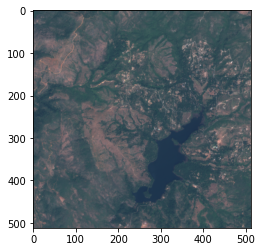

In [24]:
import ee
import numpy as np
from typing import Dict, Tuple

def get_prediction_patch(region: Dict, patch_size: int = 256) -> Tuple[str, np.ndarray]:
  year = region['year']
  lat = region['lat']
  lon = region['lon']
  filename = f"{region['name']}/{year}"
  image = sentinel2_image(f"{region['year']}-01-01", f"{year}-12-31")
  patch = get_patch(image, lat, lon, INPUT_BANDS, patch_size, scale=10)
  return (filename, patch)

region = {"name": "camp-fire", "lat": 39.781, "lon": -121.526, "year": 2018}
name, patch = get_prediction_patch(region, patch_size=512)
plt.imshow(render_sentinel2(patch))
print(f"{name} {patch.shape}")
print(f"dtype: {patch.dtype}")

## Model prediction

In [25]:
import tensorflow as tf

model = tf.keras.models.load_model("model")
model.summary()

Model: "land-cover-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Normalized (Normalization)  (None, None, None, 13)    27        
                                                                 
 conv2D (Conv2D)             (None, None, None, 32)    10432     
                                                                 
 deconv2D (Conv2DTranspose)  (None, None, None, 16)    12816     
                                                                 
 landcover (Dense)           (None, None, None, 9)     153       
                                                                 
Total params: 23,428
Trainable params: 23,401
Non-trainable params: 27
_________________________________________________________________


In [32]:
def predict(name: str, input_patch: np.ndarray, model_path: str = "model") -> Dict:
  model = tf.keras.models.load_model(model_path)
  inputs = np.stack([input_patch[name] for name in INPUT_BANDS], axis=-1)
  probabilities = model.predict(np.stack([inputs]))[0]
  return {
      'name': name,
      'inputs': input_patch,
      'outputs': probabilities,
  }

results = predict(name, patch, model_path="model")
probabilities = results['outputs']
print(f"probabilities: {probabilities.dtype} {probabilities.shape}")

probabilities: float32 (512, 512, 9)


predictions uint8 (512, 512)
    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


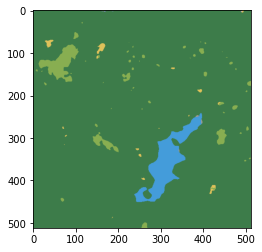

In [33]:
predictions = np.argmax(probabilities, axis=-1).astype(np.uint8)

print(f"predictions {predictions.dtype} {predictions.shape}")
plt.imshow(render_landcover(predictions))
display_legend()

## Write numpy files

In [34]:
from apache_beam.io.filesystems import FileSystems
from typing import Dict, Tuple

def write_to_numpy(results: Dict, predictions_prefix: str = "predictions"):
  filename = f"{predictions_prefix}/{results['name']}.npz"
  with FileSystems.create(filename) as f:
    np.savez_compressed(f, inputs=results["inputs"], outputs=results["outputs"])

write_to_numpy(results)

In [35]:
!ls -lh predictions/camp-fire/2018.npz

-rw-r--r-- 1 root root 14M Apr 28 16:09 predictions/camp-fire/2018.npz


## Get predictions in Beam

In [38]:
import apache_beam as beam

regions = [
    {"name": "camp-fire", "lat": 39.781, "lon": -121.526, "year": 2018},
    {"name": "camp-fire", "lat": 39.781, "lon": -121.526, "year": 2019},
    {"name": "camp-fire", "lat": 39.781, "lon": -121.526, "year": 2020},
]

with beam.Pipeline() as pipeline:
  (
      pipeline
      | "Create regions" >> beam.Create(regions)
      | "Get patch" >> beam.Map(get_prediction_patch, patch_size=512)
      | "Predict" >> beam.MapTuple(predict, model_path="model")
      | "Write to NumPy" >> beam.Map(write_to_numpy, predictions_prefix="predictions")
  )

Got patch for (39.781, -121.526)
Got patch for (39.781, -121.526)


Got patch for (39.781, -121.526)


In [39]:
!ls -lh predictions/camp-fire/*.npz

-rw-r--r-- 1 root root 14M Apr 28 16:10 predictions/camp-fire/2018.npz
-rw-r--r-- 1 root root 14M Apr 28 16:10 predictions/camp-fire/2019.npz
-rw-r--r-- 1 root root 14M Apr 28 16:10 predictions/camp-fire/2020.npz


# Land cover change

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


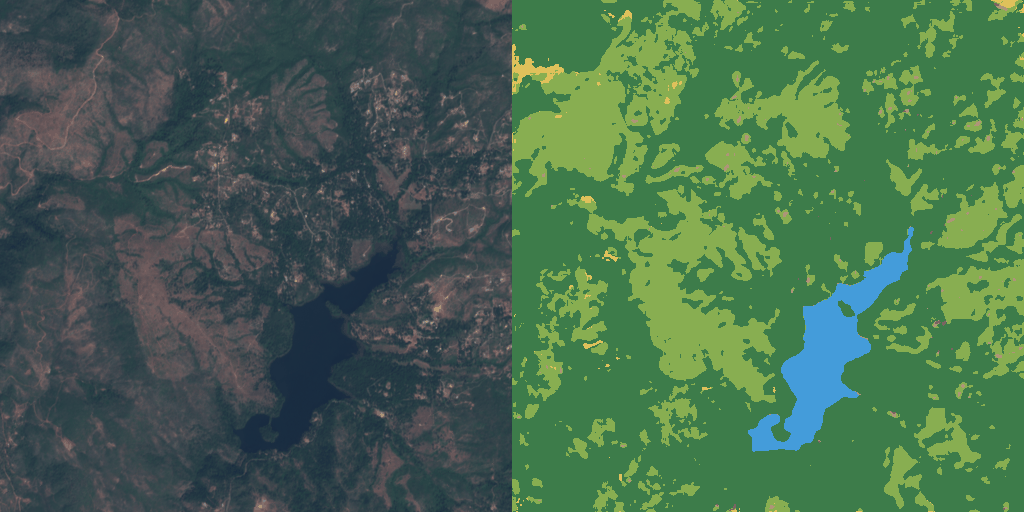

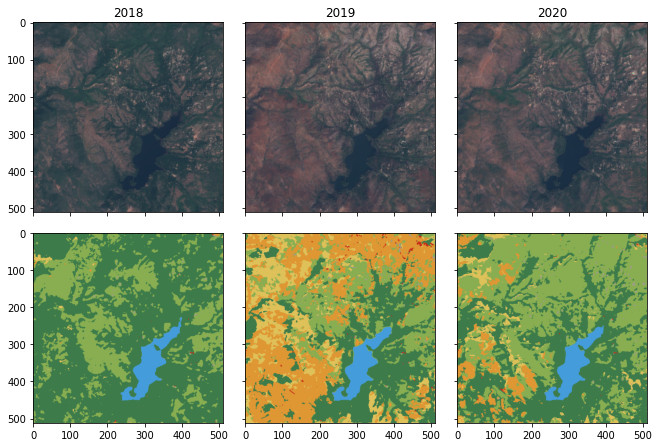

In [76]:
import numpy as np
import imageio
from IPython.display import Image

def load_results(filename: str) -> Tuple[np.ndarray, np.ndarray]:
  npz_file = np.load(filename)
  return (npz_file['inputs'], npz_file['outputs'])

def display_land_cover_change(predictions_path: str, start_year: int, end_year: int, min=0.0, max=3000.0):
  img_size = 3
  titles = [str(year) for year in range(start_year, end_year + 1)]
  figsize = (img_size * len(titles), img_size * 2)
  figure, plot_rows = plt.subplots(2, len(titles), figsize=figsize, sharex=True, sharey=True)
  figure.tight_layout(pad=0)

  results = [
      load_results(f"{predictions_path}/{year}.npz")
      for year in range(start_year, end_year + 1)
  ]
  inputs = render_sentinel2(np.stack([x for x, _ in results]), min, max)

  probabilities = np.stack([y for _, y in results])
  predictions = np.argmax(probabilities, axis=-1).astype(np.uint8)
  outputs = render_landcover(predictions)

  for title, plot, image in zip(titles, plot_rows[0], inputs):
    plot.set_title(title)
    plot.imshow(image)
  for plot, image in zip(plot_rows[1], outputs):
    plot.imshow(image)

  display_legend()

  frames = np.concatenate([inputs, outputs], axis=2)
  imageio.mimwrite('landcover-change.gif', frames, duration=1)
  return Image(open('landcover-change.gif', 'rb').read())

display_land_cover_change("predictions/camp-fire", 2018, 2020)

# Running in Google Cloud

In [109]:
# TODO: UPDATE WITH main BRANCH!
%cd /content
!rm -rf python-docs-samples
# !git clone -b ppai-landcover https://github.com/GoogleCloudPlatform/python-docs-samples/
!git clone -b ppai-landcover https://github.com/davidcavazos/python-docs-samples/
%cd python-docs-samples/people-and-planet-ai/land-cover-classification/

/content
Cloning into 'python-docs-samples'...
remote: Enumerating objects: 64869, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 64869 (delta 19), reused 39 (delta 16), pack-reused 64821
Receiving objects: 100% (64869/64869), 81.82 MiB | 31.18 MiB/s, done.
Resolving deltas: 100% (37158/37158), done.
/content/python-docs-samples/people-and-planet-ai/land-cover-classification


## Create the datasets in Dataflow

In [42]:
patch_size = 16

In [ ]:
!python create_datasets.py \
    --training-prefix "gs://{bucket}/land-cover/datasets/training" \
    --validation-prefix "gs://{bucket}/land-cover/datasets/validation" \
    --points-per-region 100 \
    --patch-size {patch_size} \
    --runner "DataflowRunner" \
    --project "{project}" \
    --region "{location}" \
    --temp_location "gs://{bucket}/land-cover/temp" \
    --setup_file "./setup.py"

https://console.cloud.google.com/dataflow/jobs

In [52]:
# TODO: UDPATE
!gsutil du -sh gs://{bucket}/land-cover/datasets/training*.tfrecord.gz
!gsutil du -sh gs://{bucket}/land-cover/datasets/validation*.tfrecord.gz

45.58 MiB    gs://dcavazos-lyra/land-cover/datasets/training*.tfrecord.gz
2.59 MiB     gs://dcavazos-lyra/land-cover/datasets/validation*.tfrecord.gz


## Train the model in Vertex AI

https://cloud.google.com/vertex-ai/docs/training/pre-built-containers

https://pypi.org/project/google-cloud-aiplatform/

https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.CustomTrainingJob

In [53]:
epochs = 1000

In [ ]:
from google.cloud import aiplatform

aiplatform.init(project=project, location=location, staging_bucket=bucket)

job = aiplatform.CustomTrainingJob(
    display_name=f"land_cover_{epochs}",
    script_path="train_model.py",
    container_uri="us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-8:latest",
)

model = job.run(
    accelerator_type='NVIDIA_TESLA_K80',
    accelerator_count=1,
    args=[
        # TODO: SIMPLIFY
        f"--training-data=gs://{bucket}/land-cover/datasets-500/training*.tfrecord.gz",
        f"--validation-data=gs://{bucket}/land-cover/datasets-500/validation*.tfrecord.gz",
        f"--model-path=gs://{bucket}/land-cover/model-{epochs}",
        f"--patch-size={patch_size}",
        f"--epochs={epochs}",
    ],
)

https://console.cloud.google.com/vertex-ai/training/training-pipelines

In [101]:
!gsutil ls -lh gs://{bucket}/land-cover/model-1000

       0 B  2022-04-05T19:36:29Z  gs://dcavazos-lyra/land-cover/model-1000/
 10.78 KiB  2022-04-28T16:35:01Z  gs://dcavazos-lyra/land-cover/model-1000/keras_metadata.pb
139.25 KiB  2022-04-28T16:35:00Z  gs://dcavazos-lyra/land-cover/model-1000/saved_model.pb
                                 gs://dcavazos-lyra/land-cover/model-1000/assets/
                                 gs://dcavazos-lyra/land-cover/model-1000/variables/
TOTAL: 3 objects, 153638 bytes (150.04 KiB)


In [103]:
import apache_beam as beam

lat, lon = 39.781, -121.526
regions = [
    {"name": "camp-fire", "lat": lat, "lon": lon, "year": 2018},
    {"name": "camp-fire", "lat": lat, "lon": lon, "year": 2019},
    {"name": "camp-fire", "lat": lat, "lon": lon, "year": 2020},
]

with beam.Pipeline() as pipeline:
  (
      pipeline
      | "Create regions" >> beam.Create(regions)
      | "Get patch" >> beam.Map(get_prediction_patch, patch_size=512)
      | "Predict" >> beam.MapTuple(predict, model_path=f"gs://{bucket}/land-cover/model-1000")
      | "Write to NumPy" >> beam.Map(write_to_numpy, predictions_prefix="predictions/vertex")
  )

Got patch for (39.781, -121.526)
Got patch for (39.781, -121.526)
Got patch for (39.781, -121.526)


    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


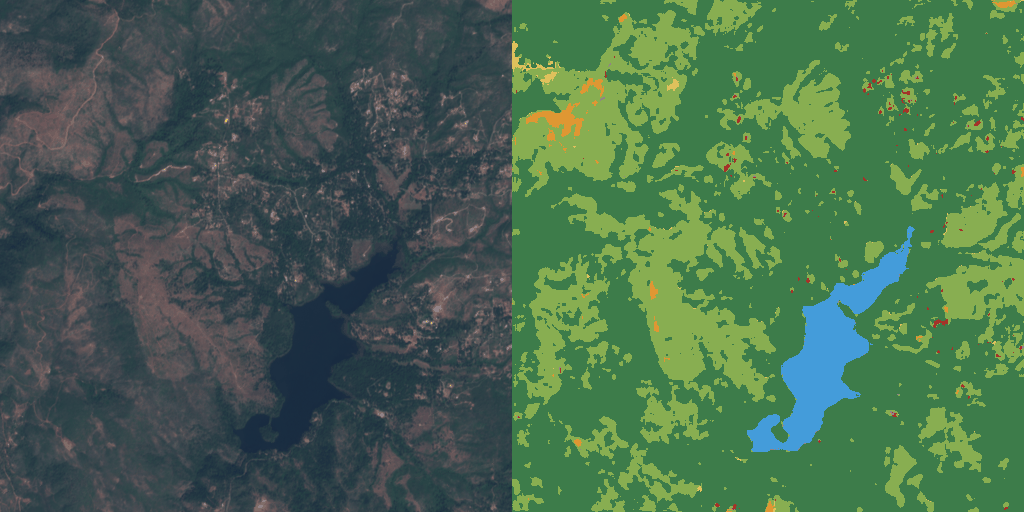

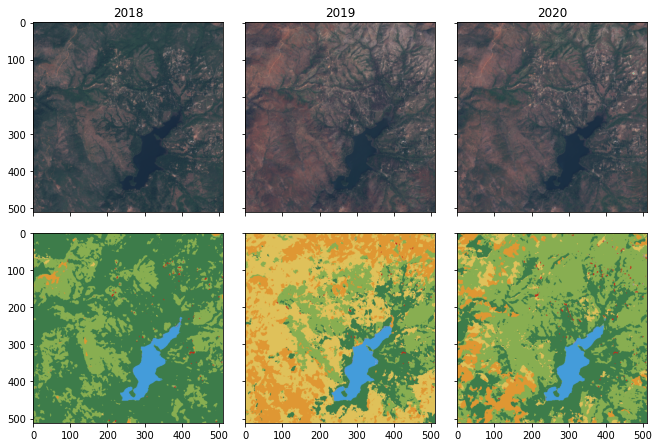

In [104]:
display_land_cover_change("predictions/vertex/camp-fire", 2018, 2020)

## Batch predictions in Dataflow

In [ ]:
!python batch_predict.py \
    --model-path "gs://{bucket}/land-cover/model-1000" \
    --predictions-prefix "gs://{bucket}/land-cover/predictions" \
    --patch-size 512 \
    --runner "DataflowRunner" \
    --project "{project}" \
    --region "{location}" \
    --temp_location "gs://{bucket}/land-cover/temp" \
    --setup_file "./setup.py"

In [94]:
import apache_beam as beam

name = "kuma-river-dam-removal"
lat, lon = 32.423, 130.646
regions = [
    {"name": name, "lat": lat, "lon": lon, "year": 2016},
    {"name": name, "lat": lat, "lon": lon, "year": 2017},
    {"name": name, "lat": lat, "lon": lon, "year": 2018},
    {"name": name, "lat": lat, "lon": lon, "year": 2019},
    {"name": name, "lat": lat, "lon": lon, "year": 2020},
]

with beam.Pipeline() as pipeline:
  (
      pipeline
      | "Create regions" >> beam.Create(regions)
      | "Get patch" >> beam.Map(get_prediction_patch, patch_size=512)
      | "Predict" >> beam.MapTuple(predict, model_path=f"gs://{bucket}/land-cover/model-{epochs}")
      | "Write to NumPy" >> beam.Map(write_to_numpy, predictions_prefix="predictions/vertex")
  )

Got patch for (32.423, 130.646)
Got patch for (32.423, 130.646)
Got patch for (32.423, 130.646)
Got patch for (32.423, 130.646)
Got patch for (32.423, 130.646)


    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


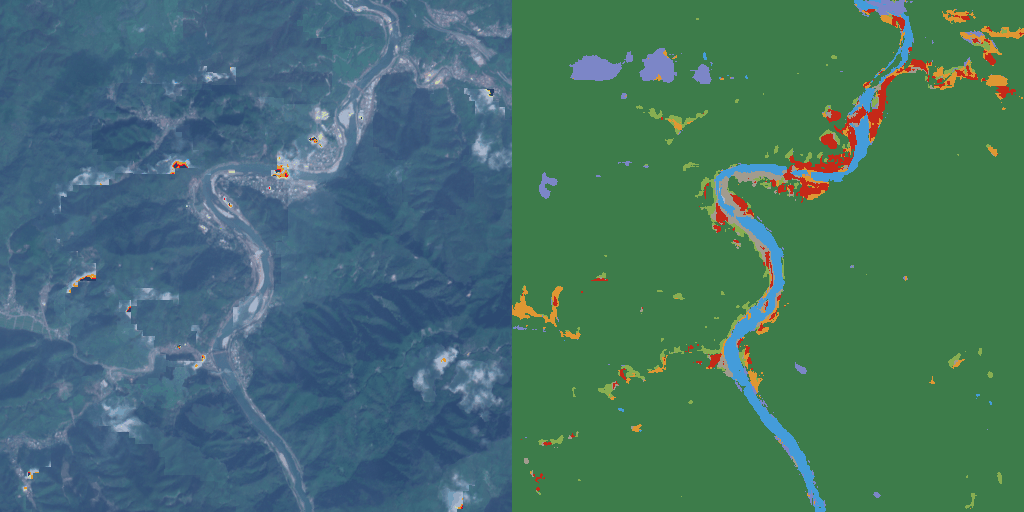

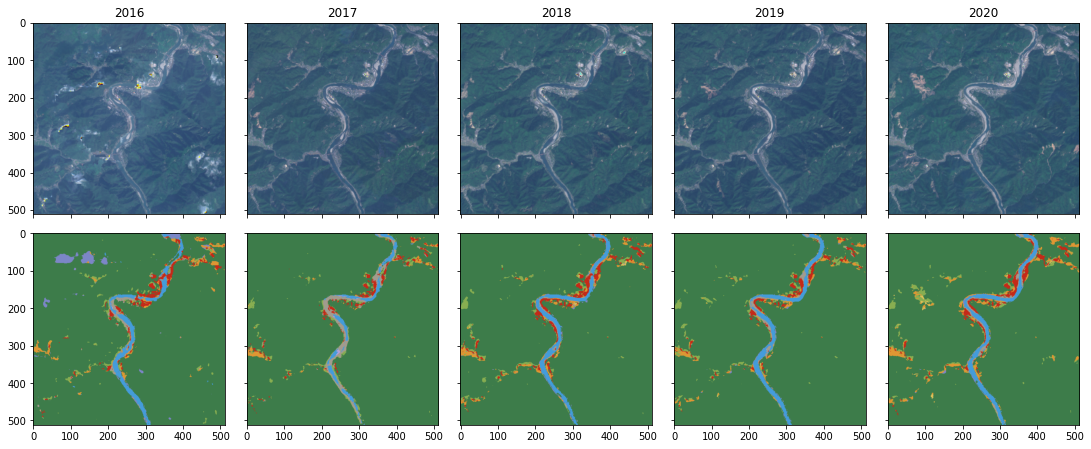

In [97]:
display_land_cover_change(f"predictions/vertex/{name}", 2016, 2020, max=2000)